In [36]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("INFY", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-05,7.555,7.475,7.525,7.510,11927400.0,6.720775
2017-01-06,7.430,7.230,7.355,7.410,27104200.0,6.631284
2017-01-09,7.520,7.340,7.355,7.480,19123800.0,6.693928
2017-01-10,7.480,7.385,7.405,7.390,22058600.0,6.613386
2017-01-11,7.610,7.390,7.400,7.595,25168000.0,6.796843


In [37]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [38]:
mavg

Date
2009-12-31         NaN
2010-01-04         NaN
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
                ...   
2017-01-05    6.839497
2017-01-06    6.834073
2017-01-09    6.830384
2017-01-10    6.826022
2017-01-11    6.823671
Name: Adj Close, Length: 1770, dtype: float64

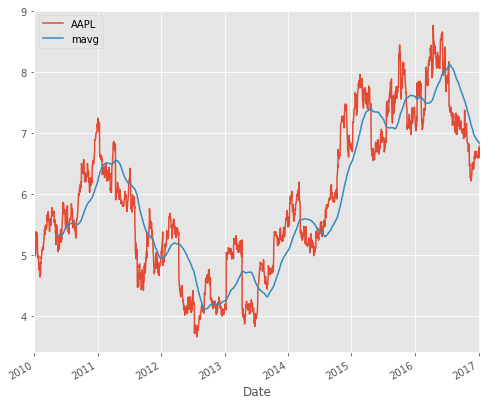

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

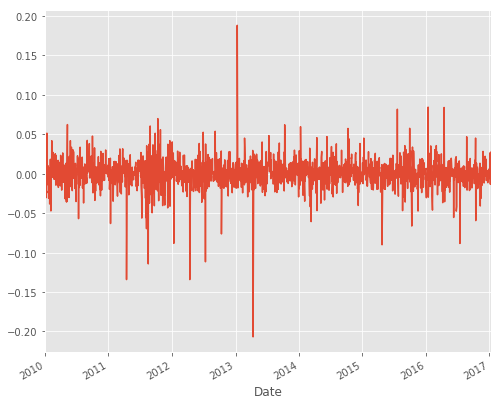

In [40]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [41]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [42]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

In [43]:
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.381874,0.411879,0.384136,0.393774
GE,0.381874,1.000000,0.422484,0.535500,0.474513
GOOG,0.411879,0.422484,1.000000,0.403215,0.472263
IBM,0.384136,0.535500,0.403215,1.000000,0.496951
MSFT,0.393774,0.474513,0.472263,0.496951,1.000000


Text(0,0.5,'Returns GE')

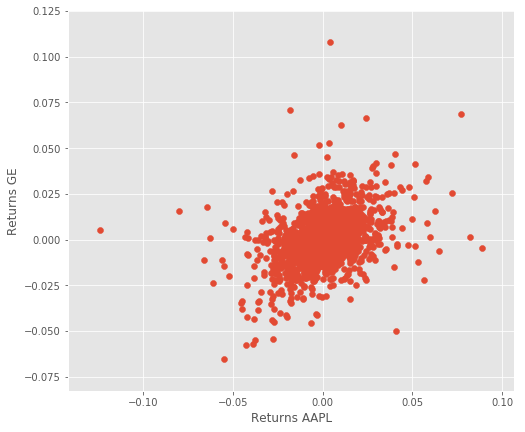

In [44]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

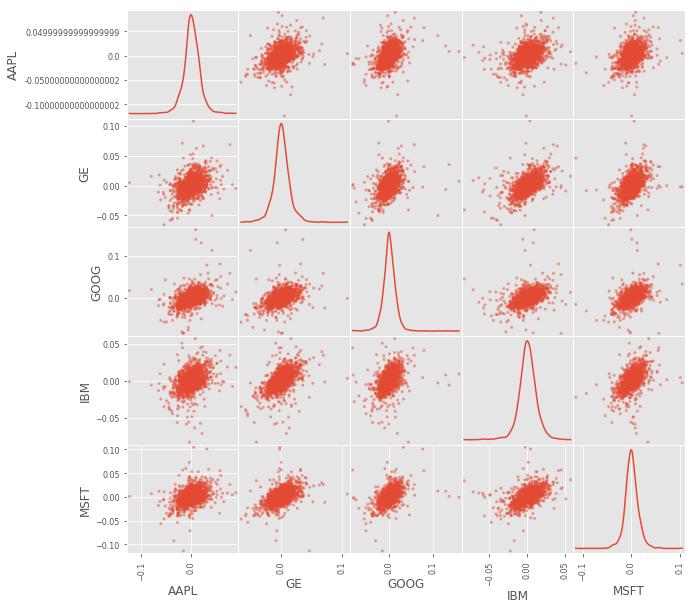

In [45]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

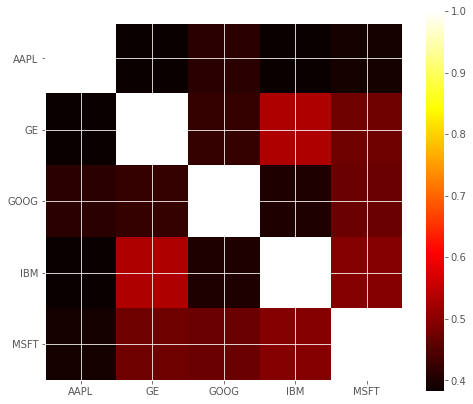

In [46]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

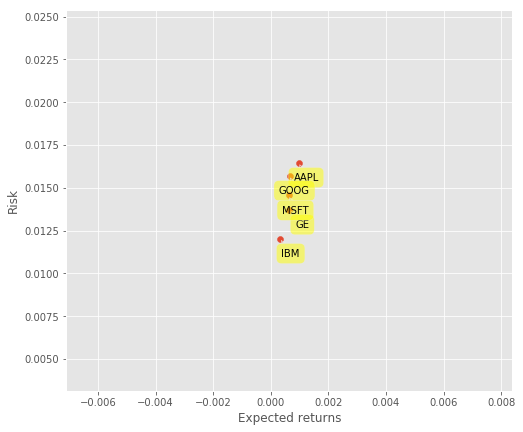

In [47]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [48]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [49]:
dfreg

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2009-12-31,5.065150,5848000.0,0.904650,-0.504048
2010-01-04,5.201698,11443200.0,1.568011,1.320953
2010-01-05,5.221861,8181600.0,1.070552,0.493825
2010-01-06,5.142131,11821600.0,1.461421,-0.830684
2010-01-07,4.985420,20374400.0,1.746318,-1.234568
...,...,...,...,...
2017-01-05,6.720775,11927400.0,1.065245,-0.199334
2017-01-06,6.631284,27104200.0,2.699053,0.747788
2017-01-09,6.693928,19123800.0,2.406415,1.699524


In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import seaborn as sb
import pandas as pd
import math
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

%matplotlib inline

In [51]:
# Drop missing value
import math

dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [53]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [55]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [56]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

5.938181311329596
[ 1.12478645 -0.02879262  0.03526453 -0.00260435]


In [57]:
y_pred = regressor.predict(X_test)

In [58]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,6.007661,5.813554
1,4.577374,4.278892
2,4.763704,4.592242
3,4.493548,5.491746
4,5.097664,5.096459
...,...,...
346,7.675370,7.541128
347,5.321481,5.580431
348,5.371598,5.998619
349,8.209783,8.104432


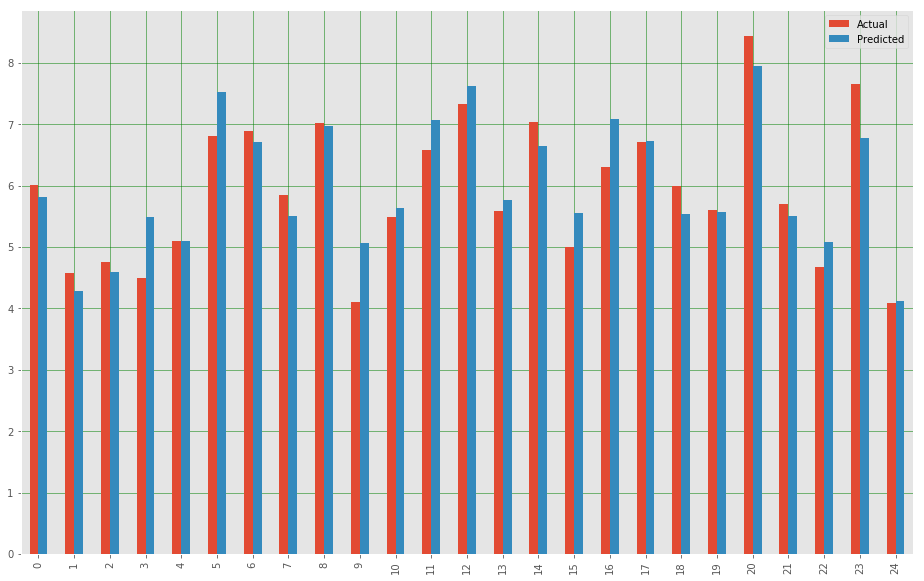

In [59]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [65]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [68]:
#To retrieve the intercept:
print(clfpoly2)
#For retrieving the slope:
print(clfpoly2)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])


In [69]:
clfpoly2_pred = clfpoly2.predict(X_test)

In [74]:
clfpoly2 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': clfpoly2_pred.flatten()})
clfpoly2

,Actual,Predicted
0,6.007661,5.834132
1,4.577374,4.271295
2,4.763704,4.503852
3,4.493548,5.505690
4,5.097664,5.116899
...,...,...
346,7.675370,7.537588
347,5.321481,5.593489
348,5.371598,6.009628
349,8.209783,8.065119


In [75]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [98]:
#len(X)
len(y)

1752

ValueError: x and y must be the same size

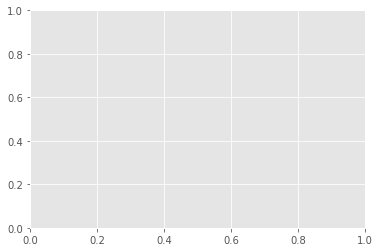

In [99]:
plt.scatter(X,y)
plt.ylabels()
plt.Xlabels()
plt.show()

In [100]:
#x = X_train.reshape(-1,1)

In [101]:
#y = y_train.reshape(-1,1)

In [ ]:
# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Visualizing the Linear Regression results
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lin_reg.predict(X), color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Position level')
    plt.ylabel('Salary')
    plt.show()
    return
viz_linear()

In [103]:
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [105]:
print(clfknn.score(X_train, y_train))
print(clfknn.score(X_test, y_test))

0.9361372549542618
0.8181959706248657


In [110]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
seed = 4
kfold = model_selection.KFold(n_splits=5, random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 3

    

In [114]:
from sklearn.ensemble import AdaBoostClassifier
seed = 7
num_trees = 30
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

ValueError: Unknown label type: 'continuous'